### `GoogLeNet (Inception)`
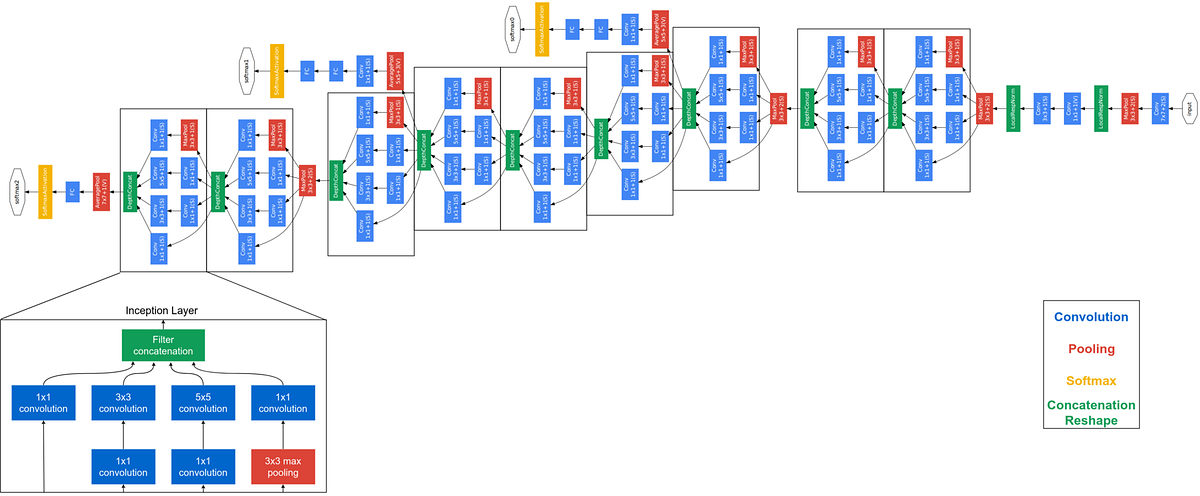

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

#### Get data from dataset

In [16]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    "/kaggle/input/5-vehichles-for-multicategory-classification/dataset/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

valid_ds = image_dataset_from_directory(
    "/kaggle/input/5-vehichles-for-multicategory-classification/dataset/validation",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = image_dataset_from_directory(
    "/kaggle/input/5-vehichles-for-multicategory-classification/dataset/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)


class_names = train_ds.class_names
num_classes = len(class_names)

print(f"\nClass Names: {class_names}")

Found 5418 files belonging to 5 classes.
Found 709 files belonging to 5 classes.
Found 708 files belonging to 5 classes.

Class Names: ['bus', 'car', 'motorcycle', 'train', 'truck']


#### Preprocessing

In [17]:
normalization = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization(x), y))
valid_ds   = valid_ds.map(lambda x, y: (normalization(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization(x), y))

data_aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

#### Get Pretrained model

In [18]:
GoogLeNet = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3),
)

#### Make Fine Tuning to make last 5 layers be trainable

In [19]:
# Freeze All Layers
for layer in GoogLeNet.layers:
    layer.trainable = False

for layer in GoogLeNet.layers[5:]:
    layer.trainable = True

#### Build the main model

In [20]:
model = tf.keras.Sequential([
    data_aug,
    GoogLeNet,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(5, activation='softmax')
])

#### Compile the model and choose the optimizer

In [21]:
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### Make Early Stopping

In [22]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

#### Training

In [23]:
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=valid_ds,
    callbacks=[early_stop]
)

Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 109s 388ms/step - accuracy: 0.4625 - loss: 1.3490 - val_accuracy: 0.8350 - val_loss: 0.4443
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 353ms/step - accuracy: 0.7331 - loss: 0.7012 - val_accuracy: 0.8491 - val_loss: 0.4255
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 351ms/step - accuracy: 0.7912 - loss: 0.5657 - val_accuracy: 0.8561 - val_loss: 0.3905
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 351ms/step - accuracy: 0.8274 - loss: 0.4842 - val_accuracy: 0.8660 - val_loss: 0.3751
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 351ms/step - accuracy: 0.8416 - loss: 0.4335 - val_accuracy: 0.8773 - val_loss: 0.3395
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 351ms/step - accuracy: 0.8589 - loss: 0.3923 - val_accuracy: 0.8717 - val_loss: 0.3295
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 352ms/step - accuracy: 0.8697 - loss: 0.3479 - val_accuracy: 0.8872 - val_loss: 0.3278
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 60s 352ms/step - accuracy: 0.8821 - loss: 

#### Evaluate on test data

In [25]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)
print("Test Loss:", test_loss)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - accuracy: 0.9161 - loss: 0.2721
Test Accuracy: 0.8940678238868713
Test Loss: 0.3196674883365631


In [38]:
import numpy as np
import random

batches = list(test_ds)
images, labels = random.choice(batches)
preds = model.predict(images)
pred_labels = np.argmax(preds, axis=1)
num_images = min(len(images), 8)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step


#### Show some predictions on batch

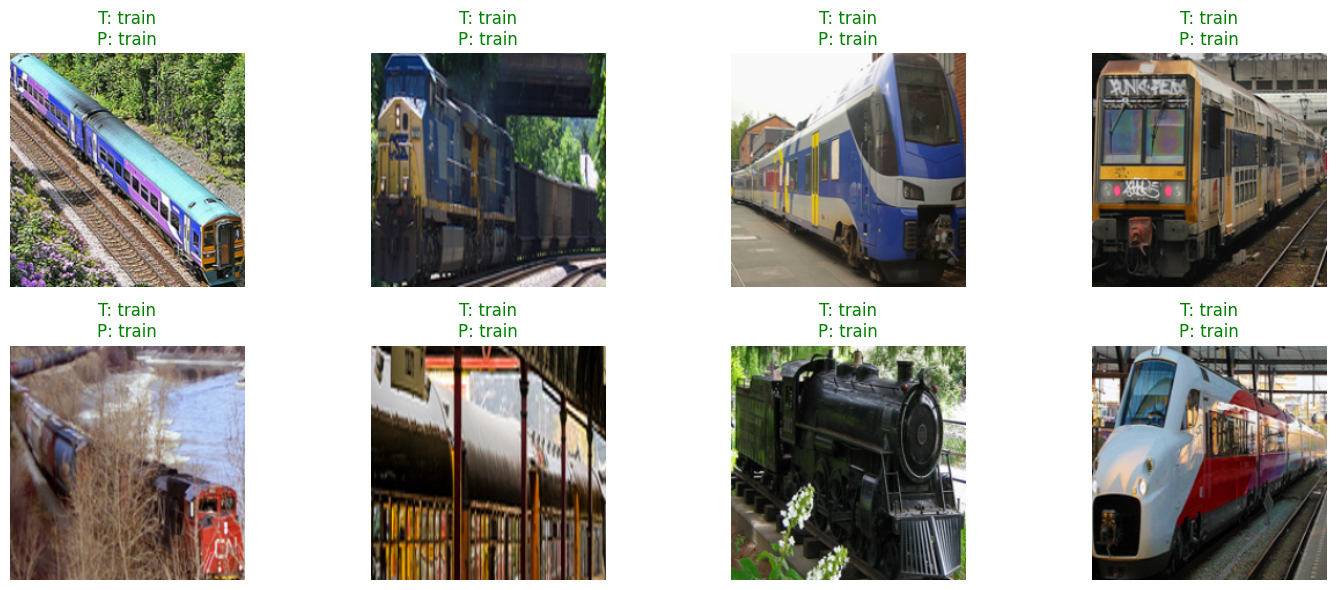

In [41]:
plt.figure(figsize=(15, 6))

for i in range(num_images):
    plt.subplot(2, 4, i + 1)

    img = images[i].numpy()
    img = (img - img.min()) / (img.max() - img.min())

    plt.imshow(img)
    plt.axis('off')

    true_label = class_names[int(labels[i])]
    pred_label = class_names[int(pred_labels[i])]

    color = "green" if labels[i] == pred_labels[i] else "red"

    plt.title(f"T: {true_label}\nP: {pred_label}", color=color)

plt.tight_layout()
plt.show()